# Grab-Microsoft Challenge 
## Traffic Management

- geohash6: geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa.(Examples:https://github.com/hkwi/python-geohash)
- day: the value indicates the sequential order and not a particular day of the month
- timestamp: start time of 15-minute intervals in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)
- demand: aggregated demand normalised to be in the range [0,1]

### This is dataset features generation 
- Feature Engineering

#### Import python library

In [1]:
import pandas as pd   # for reading datasets
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler # for encoding geohash and data normalisation
import matplotlib.pyplot as plt # for Chart ploting

# to scale the data
from sklearn.preprocessing import StandardScaler
import joblib # for saving scaler

# For Clustering check
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import geohash      # for geohash conversion
try:
    import _geohash
except ImportError:
    _geohash = None

### Define Function

In [2]:
#=========================================================================
# Function to Check on data spread and Normality
#=========================================================================

def Normality_Check(feature):
    
    subtitle = feature + ' Data'
    title1 = feature + " Count"
    title2 = feature + ' Spread'
    filename = feature + '_normality_check.png'
    
    # Ploting two figure side by side
    fig = plt.figure(figsize=(60,20)) #  figure
    fig.suptitle(subtitle, fontsize=40, fontweight='bold')
    ax1 = fig.add_subplot(121)
    
    ax1.set_title(title1, fontsize=30)
    ax1.xaxis.set_tick_params(labelsize=30)
    ax1.yaxis.set_tick_params(labelsize=30)
    ax2 = fig.add_subplot(122)
    
    ax2.set_title(title2, fontsize=30)
    ax2.xaxis.set_tick_params(labelsize=30)
    ax2.yaxis.set_tick_params(labelsize=30)

    plt.subplot(121) # 1st figure
    df[feature].hist(bins=50)

    plt.subplot(122) # 2nd figure
    df.boxplot(column=feature)
    # Save the chart to file
    plt.savefig(filename, bbox_inches="tight")

_base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
_base32_map = {}
for i in range(len(_base32)):
    _base32_map[_base32[i]] = i
    
# To decode the geohash to Lonitude and latitude
def _decode_c2i(hashcode):
    lon = 0
    lat = 0
    bit_length = 0
    lat_length = 0
    lon_length = 0
    for i in hashcode:
        t = _base32_map[i]
        if bit_length%2==0:
            lon = lon<<3
            lat = lat<<2
            lon += (t>>2)&4
            lat += (t>>2)&2
            lon += (t>>1)&2
            lat += (t>>1)&1
            lon += t&1
            lon_length+=3
            lat_length+=2
        else:
            lon = lon<<2
            lat = lat<<3
            lat += (t>>2)&4
            lon += (t>>2)&2
            lat += (t>>1)&2
            lon += (t>>1)&1
            lat += t&1
            lon_length+=2
            lat_length+=3

        bit_length+=5

    return (lat,lon,lat_length,lon_length)

def decode(hashcode, delta=False):
    '''
    decode a hashcode and get center coordinate, and distance between center and outer border
    '''
    if _geohash:
        (lat,lon,lat_bits,lon_bits) = _geohash.decode(hashcode)
        latitude_delta = 90.0/(1<<lat_bits)
        longitude_delta = 180.0/(1<<lon_bits)
        latitude = lat + latitude_delta
        longitude = lon + longitude_delta
        if delta:
            return latitude,longitude,latitude_delta,longitude_delta
        return latitude,longitude
 
    (lat,lon,lat_length,lon_length) = _decode_c2i(hashcode)
 
    if hasattr(float, "fromhex"):
        latitude_delta  = 90.0/(1<<lat_length)
        longitude_delta = 180.0/(1<<lon_length)
        latitude = _int_to_float_hex(lat, lat_length) * 90.0 + latitude_delta
        longitude = _int_to_float_hex(lon, lon_length) * 180.0 + longitude_delta
        if delta:
            return latitude,longitude,latitude_delta,longitude_delta
        return latitude,longitude
 
    lat = (lat<<1) + 1
    lon = (lon<<1) + 1
    lat_length += 1
    lon_length += 1
 
    latitude  = 180.0*(lat-(1<<(lat_length-1)))/(1<<lat_length)
    longitude = 360.0*(lon-(1<<(lon_length-1)))/(1<<lon_length)
    if delta:
        latitude_delta  = 180.0/(1<<lat_length)
        longitude_delta = 360.0/(1<<lon_length)
        return latitude,longitude,latitude_delta,longitude_delta
 
    return latitude,longitude

#### Reading from training dataset

In [3]:
df = pd.read_csv("data/training.csv")
df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:00,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:00,0.088755
4,qp090q,15,4:00,0.074468


- Read dataset metric data statistics
- Check for data integrity

In [4]:
# As can see from the summary, all the features has different range
df.describe()

,day,demand
count,1.048575e+06,1.048575e+06
mean,3.146812e+01,1.048976e-01
std,1.767886e+01,1.588668e-01
min,1.000000e+00,3.040000e-08
25%,1.600000e+01,1.869865e-02
50%,3.200000e+01,5.046788e-02
75%,4.700000e+01,1.204841e-01
max,6.100000e+01,1.000000e+00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   geohash6   1048575 non-null  object 
 1   day        1048575 non-null  int64  
 2   timestamp  1048575 non-null  object 
 3   demand     1048575 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [6]:
# check how many days of data
print("There are total {} days".format(len(df["day"].unique())))
np.sort(df["day"].unique())

There are total 61 days


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61], dtype=int64)

In [7]:
# check number of unique timestamp
print("There are total {} timestamp".format(len(df["timestamp"].unique())))
np.sort(df["timestamp"].unique())

There are total 96 timestamp


array(['0:00', '0:15', '0:30', '0:45', '10:00', '10:15', '10:30', '10:45',
       '11:00', '11:15', '11:30', '11:45', '12:00', '12:15', '12:30',
       '12:45', '13:00', '13:15', '13:30', '13:45', '14:00', '14:15',
       '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00',
       '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45',
       '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30',
       '19:45', '1:00', '1:15', '1:30', '1:45', '20:00', '20:15', '20:30',
       '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15',
       '22:30', '22:45', '23:00', '23:15', '23:30', '23:45', '2:00',
       '2:15', '2:30', '2:45', '3:00', '3:15', '3:30', '3:45', '4:00',
       '4:15', '4:30', '4:45', '5:00', '5:15', '5:30', '5:45', '6:00',
       '6:15', '6:30', '6:45', '7:00', '7:15', '7:30', '7:45', '8:00',
       '8:15', '8:30', '8:45', '9:00', '9:15', '9:30', '9:45'],
      dtype=object)

### Which areas have high / low traffic demand?

In [8]:
# In order to know visually which area is in high demand need to know the unque geohash has 
# the higher numbers of count
geohashes_group = df.groupby("geohash6", as_index=False)\
.agg({"day":"count"})\
.rename(columns={"day":"count"})\
.sort_values(by="count", ascending=False)

In [9]:
geohashes_group

,geohash6,count
141,qp03r3,1534
631,qp096t,1530
502,qp092m,1526
637,qp096z,1523
628,qp096q,1515
...,...,...
1247,qp0d5n,1
825,qp09eg,1
966,qp09kg,1
1002,qp09mv,1


In [10]:
geohashes_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1314 entries, 141 to 984
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   geohash6  1314 non-null   object
 1   count     1314 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.8+ KB


In [11]:
geohashes_group[['lat','long']] = geohashes_group['geohash6'].apply(lambda x: pd.Series(decode(x)))
geohashes_group

,geohash6,count,lat,long
141,qp03r3,1534,-5.397034,90.675659
631,qp096t,1530,-5.375061,90.818481
502,qp092m,1526,-5.375061,90.719604
637,qp096z,1523,-5.364075,90.829468
628,qp096q,1515,-5.369568,90.807495
...,...,...,...,...
1247,qp0d5n,1,-5.237732,90.840454
825,qp09eg,1,-5.342102,90.873413
966,qp09kg,1,-5.386047,90.917358
1002,qp09mv,1,-5.375061,90.961304


#### Create geohash cluster

In [12]:
# For proper clustering , is best to convert the lat and long data to standard scaling
# Create a temp lat-long data for clustering check
latlong = geohashes_group[["lat", "long"]].values
latlong = np.nan_to_num(latlong) # In case any too small or large number generated
latlong = StandardScaler().fit_transform(latlong)

print(latlong.shape)
latlong

(1314, 2)


array([[-0.70650955, -1.03046278],
       [-0.37229893,  0.30123378],
       [-0.37229893, -0.62070999],
       ...,
       [-0.53940424,  1.22317756],
       [-0.37229893,  1.63293034],
       [-0.62295689,  1.42805395]])

- use two methods to check for clustering
  - Silhouette Coefficient
  - KMeans Elbow method

In [13]:
# Silhouette Coefficient: Combines both the Cohesion and Separation
score = []
results = []
values = np.arange(2, 80)

for n_cluster in values:
    kmeans = KMeans(n_clusters=n_cluster).fit(latlong)
    label = kmeans.labels_
    # get inertia
    inertia = kmeans.inertia_
    sil_coeff = silhouette_score(latlong, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    score.append(sil_coeff)
    # add results to list
    results.append({'n':n_cluster, 'sil_coef':sil_coeff, 'inertia':inertia})

For n_clusters=2, The Silhouette Coefficient is 0.3551566752911839
For n_clusters=3, The Silhouette Coefficient is 0.3886239202353945
For n_clusters=4, The Silhouette Coefficient is 0.3906295108084326
For n_clusters=5, The Silhouette Coefficient is 0.3690495568907571
For n_clusters=6, The Silhouette Coefficient is 0.38631952437356604
For n_clusters=7, The Silhouette Coefficient is 0.38604120426686694
For n_clusters=8, The Silhouette Coefficient is 0.3726328057888266
For n_clusters=9, The Silhouette Coefficient is 0.36878805875853543
For n_clusters=10, The Silhouette Coefficient is 0.36009955840413693
For n_clusters=11, The Silhouette Coefficient is 0.3613666577390819
For n_clusters=12, The Silhouette Coefficient is 0.36499340831557353
For n_clusters=13, The Silhouette Coefficient is 0.3677819396841059
For n_clusters=14, The Silhouette Coefficient is 0.3578953391763443
For n_clusters=15, The Silhouette Coefficient is 0.356187791912231
For n_clusters=16, The Silhouette Coefficient is 0.3

Text(0.5, 1.0, 'Silhouette score vs number of clusters')

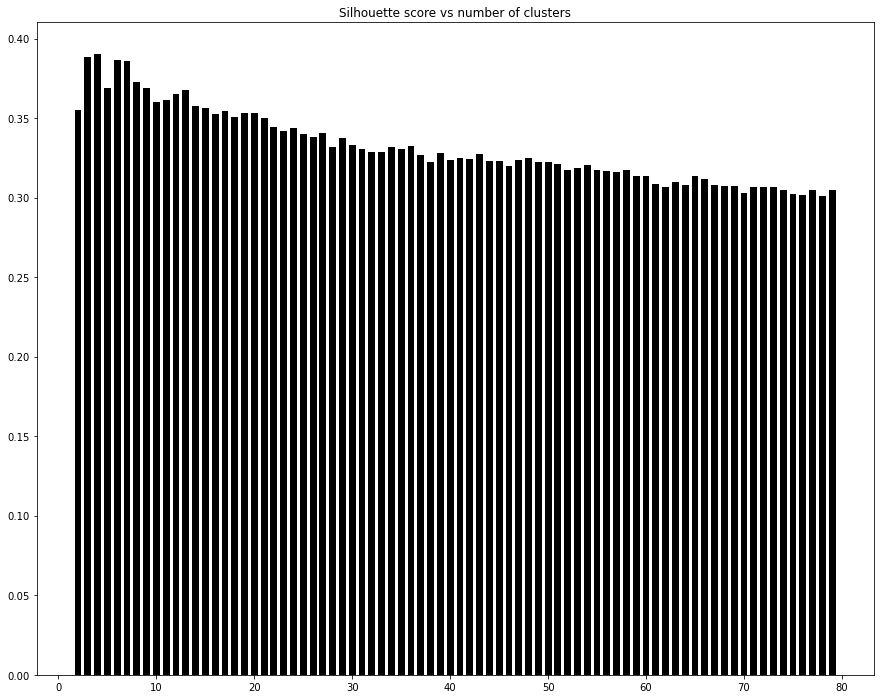

In [14]:
# Visualize the silhouette scores for various values:
# Plot silhouette scores

plt.figure(figsize=(15,12))
plt.bar(values, score, width=0.7, color='black', align='center')
plt.title('Silhouette score vs number of clusters')

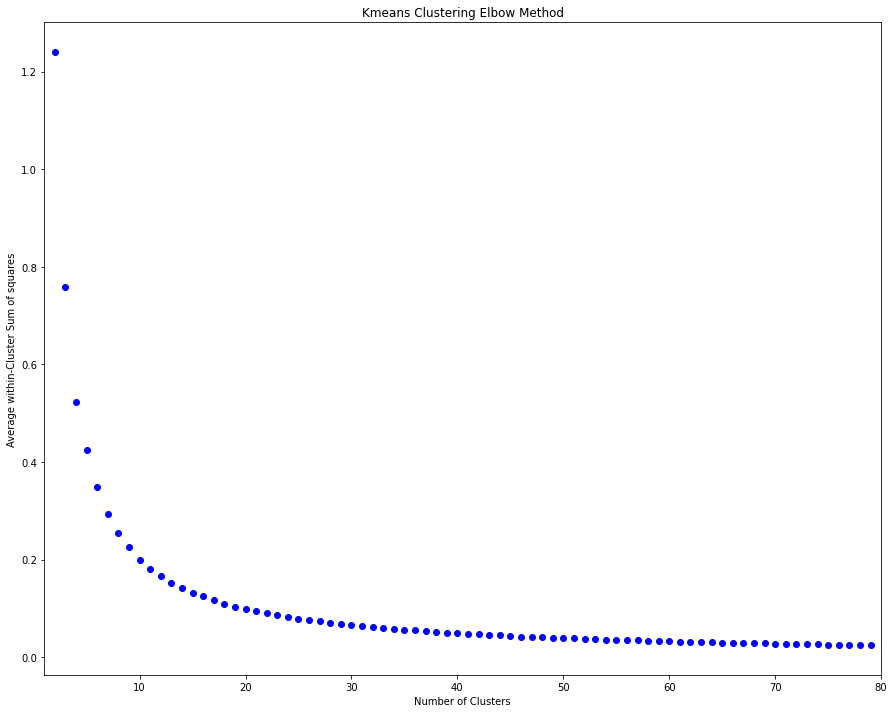

In [15]:
# KMeans Elbow method

A = []
B = []

for i in range (2 , 80):
    # fit a Kmeans model to the data
    model = KMeans(init='k-means++',n_clusters=i, n_init=10)
    model.fit(latlong)
    
    # Append number of cluster to A data list
    A.append(i)
    
    # Append average within cluster sum of squares to B data List
    SSE = model.inertia_/ latlong.shape[0]
    B.append(SSE)

# plot A & B
plt.figure(figsize=(15,12))
plt.plot(A,B,'bo')
plt.xlim((1,80))
plt.xlabel('Number of Clusters')
plt.ylabel('Average within-Cluster Sum of squares')
plt.title('Kmeans Clustering Elbow Method')

# Display the plot
plt.show()

**Note:** Since the tapping off is around 50 to 60, I will choose k=50 to cluster the locations

In [16]:
# fit a Kmeans model to the data
KMeans_model = KMeans(init='k-means++',n_clusters=50, n_init=10)
KMeans_model.fit(latlong)
cluster_centers = KMeans_model.cluster_centers_
labels = KMeans_model.labels_
print(KMeans_model)

KMeans(n_clusters=50)


In [17]:
labels

array([40, 20, 12, ...,  4, 32, 15])

In [18]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [19]:
# assign the labels back to the dataset
geohashes_group["geo_cluster"] = labels

In [20]:
geohashes_group.head(12)

,geohash6,count,lat,long,geo_cluster
141,qp03r3,1534,-5.397034,90.675659,40
631,qp096t,1530,-5.375061,90.818481,20
502,qp092m,1526,-5.375061,90.719604,12
637,qp096z,1523,-5.364075,90.829468,37
628,qp096q,1515,-5.369568,90.807495,37
815,qp09e5,1515,-5.342102,90.840454,31
865,qp09ft,1511,-5.287170,90.818481,28
144,qp03r6,1511,-5.391541,90.675659,40
247,qp03xf,1510,-5.347595,90.697632,23
675,qp0985,1509,-5.342102,90.708618,23


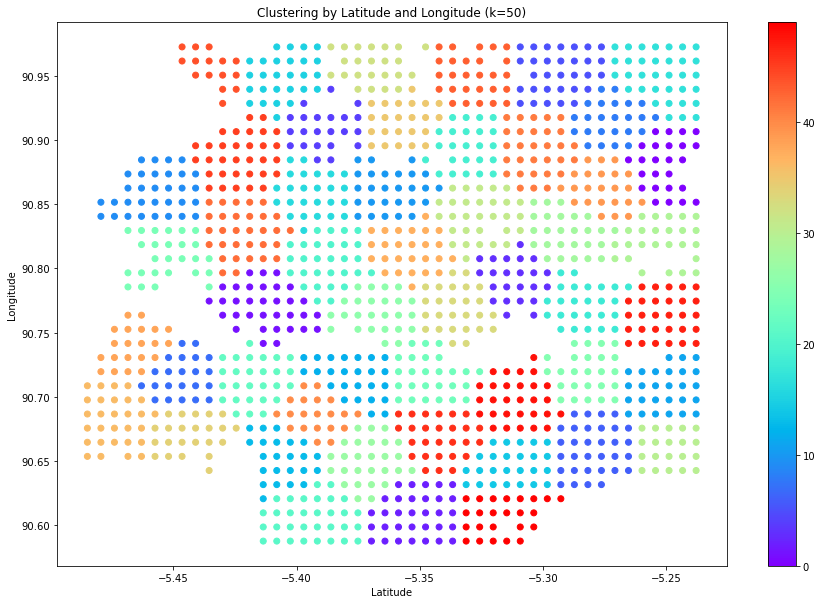

In [21]:
# Visualisation of the cluster labels
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(geohashes_group["lat"], geohashes_group["long"], c=geohashes_group["geo_cluster"], cmap="rainbow")
plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Clustering by Latitude and Longitude (k=50)")
plt.savefig("geohash_region_clustering.png", bbox_inches="tight")
plt.show()

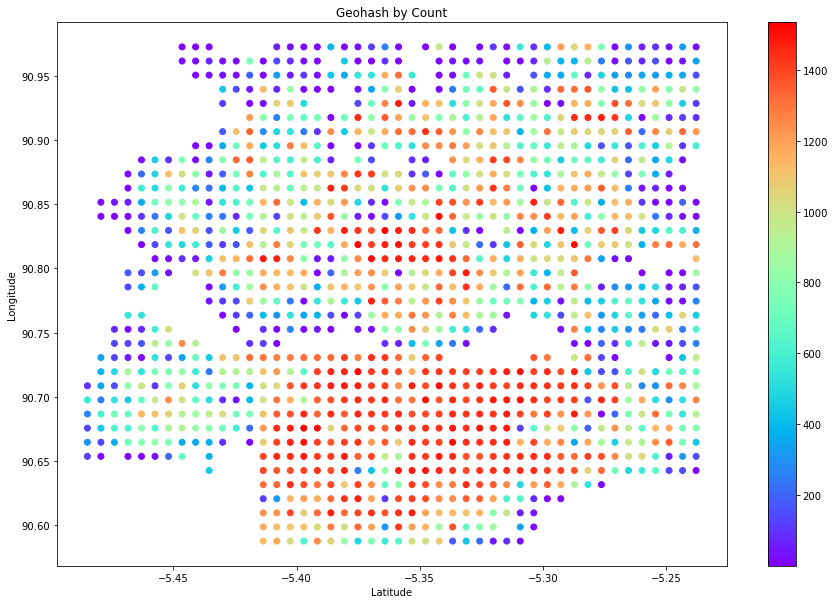

In [22]:
# Visualisation of the geohash count labels
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(geohashes_group["lat"], geohashes_group["long"], c=geohashes_group["count"], cmap="rainbow")
plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Geohash by Count")
plt.savefig("geohash_Count_clustering.png", bbox_inches="tight")
plt.show()

- Q2 : Which areas have high / low traffic demand?
- Seems like the most geohash counts are:
    - between latitude -5.4 to -5.3 
    - between longitude 90.6 to 90.75
    - Does that means more count = to more demand ?
    - with the evidence from the sort by lowest demand value that some coninsides with the same area
    - with the evidence from the sort by highest demand value that some coninsides with the same area

### Feature Engineering for the DNN Model

#### Extract hour and minute from timestamp column and Day of Week (dow)

In [23]:
# Extract hour and min from timestamp
df[['hour','min']] = df['timestamp'].str.split(':',expand=True)
df['hour'] = df['hour'].astype('int64')
df['min'] = df['min'].astype('int64')

# extract day of week (DoW) from day
df['dow'] = df['day'] % 7

#### Convert geohash to Lat & long

In [24]:
df[['lat','long']] = df['geohash6'].apply(lambda x: pd.Series(decode(x)))
df.head(30)


,geohash6,day,timestamp,demand,hour,min,dow,lat,long
0,qp03wc,18,20:00,0.020072,20,0,4,-5.353088,90.653687
1,qp03pn,10,14:30,0.024721,14,30,3,-5.413513,90.664673
2,qp09sw,9,6:15,0.102821,6,15,2,-5.325623,90.906372
3,qp0991,32,5:00,0.088755,5,0,4,-5.353088,90.752563
4,qp090q,15,4:00,0.074468,4,0,1,-5.413513,90.719604
5,qp03tu,1,12:15,0.023843,12,15,1,-5.336609,90.609741
6,qp096d,25,3:30,0.007460,3,30,4,-5.391541,90.818481
7,qp03nr,51,20:45,0.000293,20,45,2,-5.408020,90.631714
8,qp093r,48,6:15,0.054170,6,15,6,-5.364075,90.763550
9,qp03r2,4,22:15,0.123463,22,15,4,-5.402527,90.675659


#### Drop unused features

In [25]:
# Drop original column timestamp and geohash
# Since we have already converted both timestamp and geohash into more detail features
df.drop(columns=['geohash6', 'timestamp'], inplace=True)
df = df[['day', 'hour', 'min', 'dow', 'lat', 'long','demand']]
df.head(30)

,day,hour,min,dow,lat,long,demand
0,18,20,0,4,-5.353088,90.653687,0.020072
1,10,14,30,3,-5.413513,90.664673,0.024721
2,9,6,15,2,-5.325623,90.906372,0.102821
3,32,5,0,4,-5.353088,90.752563,0.088755
4,15,4,0,1,-5.413513,90.719604,0.074468
5,1,12,15,1,-5.336609,90.609741,0.023843
6,25,3,30,4,-5.391541,90.818481,0.007460
7,51,20,45,2,-5.408020,90.631714,0.000293
8,48,6,15,6,-5.364075,90.763550,0.054170
9,4,22,15,4,-5.402527,90.675659,0.123463


#### Sabe sample for testing later

In [27]:
start_sample = 8000
end_sample   = 8021
test_sample  = df[start_sample:end_sample]
test_sample

,day,hour,min,dow,lat,long,demand
8000,15,10,30,1,-5.243225,90.950317,0.002067
8001,28,1,15,0,-5.287170,90.818481,0.228930
8002,11,21,30,4,-5.375061,90.873413,0.041138
8003,56,7,15,0,-5.451965,90.708618,0.062830
8004,38,8,15,3,-5.353088,90.752563,0.159615
8005,38,3,0,3,-5.353088,90.829468,0.909942
8006,43,22,30,1,-5.254211,90.917358,0.000901
8007,19,7,0,5,-5.424500,90.730591,0.132622
8008,25,7,0,4,-5.281677,90.972290,0.193138
8009,24,2,0,3,-5.276184,90.972290,0.040870


In [28]:
writer = pd.ExcelWriter('data/test_sample8000.xlsx', engine='xlsxwriter')
test_sample.to_excel(writer, sheet_name='TrafficMgmt', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

#### normalize features

In [30]:
y = df['demand']
scaler = MinMaxScaler(feature_range=(0, 1))
df[['day','hour','min','dow','lat','long']] = scaler.fit_transform(df[['day','hour','min','dow','lat','long']])

In [31]:
scaler_filename = "grab_msft_scaler.save"
joblib.dump(scaler, scaler_filename) 

['grab_msft_scaler.save']

In [32]:
df

,day,hour,min,dow,lat,long,demand
0,0.283333,0.869565,0.000000,0.666667,0.533333,0.171429,0.020072
1,0.150000,0.608696,0.666667,0.500000,0.288889,0.200000,0.024721
2,0.133333,0.260870,0.333333,0.333333,0.644444,0.828571,0.102821
3,0.516667,0.217391,0.000000,0.666667,0.533333,0.428571,0.088755
4,0.233333,0.173913,0.000000,0.166667,0.288889,0.342857,0.074468
...,...,...,...,...,...,...,...
1048570,0.083333,0.347826,0.666667,1.000000,0.911111,0.771429,0.024022
1048571,0.366667,0.652174,0.666667,0.333333,0.111111,0.400000,0.005703
1048572,0.683333,0.652174,1.000000,0.000000,0.533333,0.200000,0.067131
1048573,0.016667,0.260870,0.666667,0.333333,0.711111,0.600000,0.151323


#### Check for data Normality

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


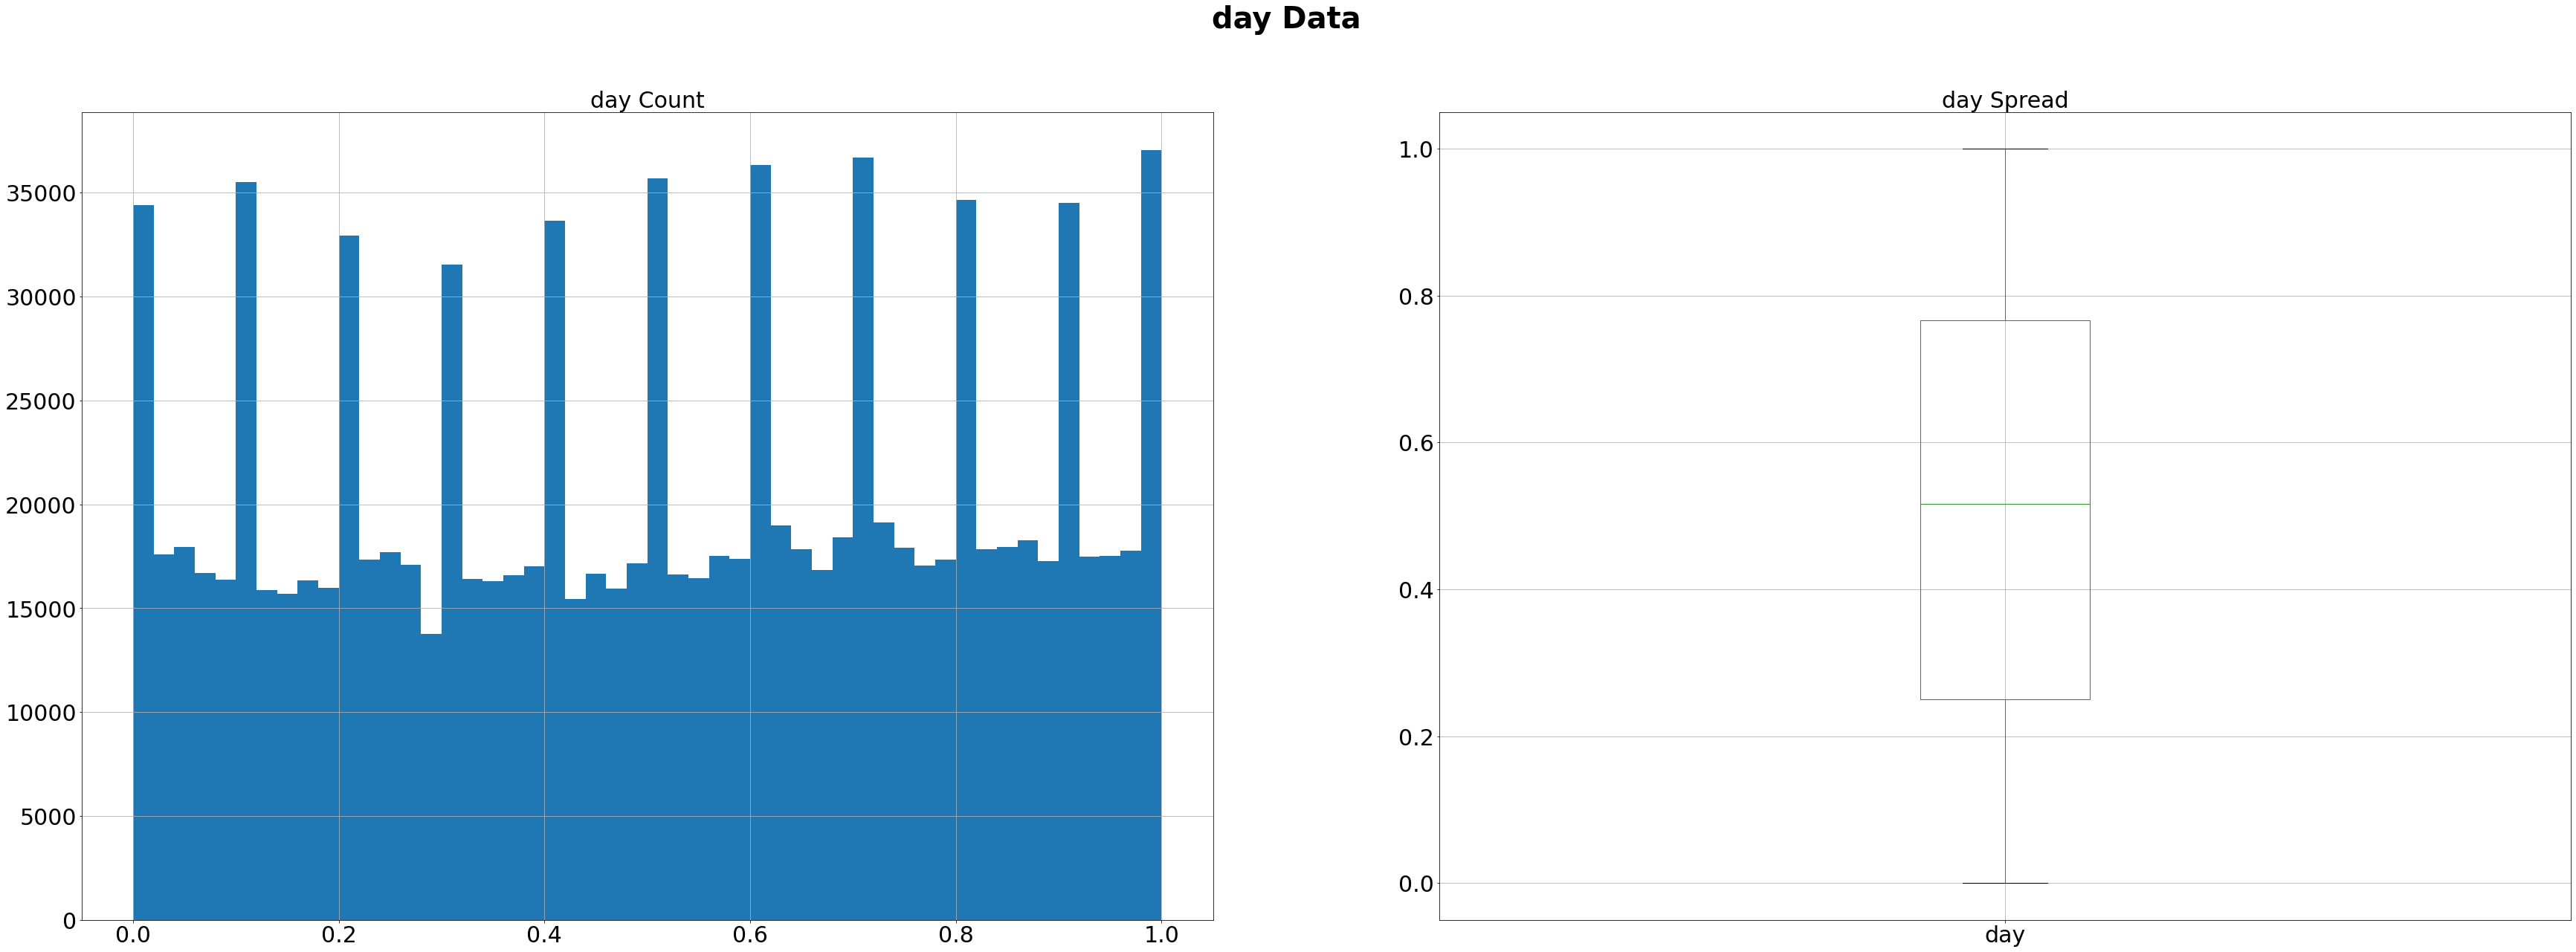

In [33]:
Normality_Check('day')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


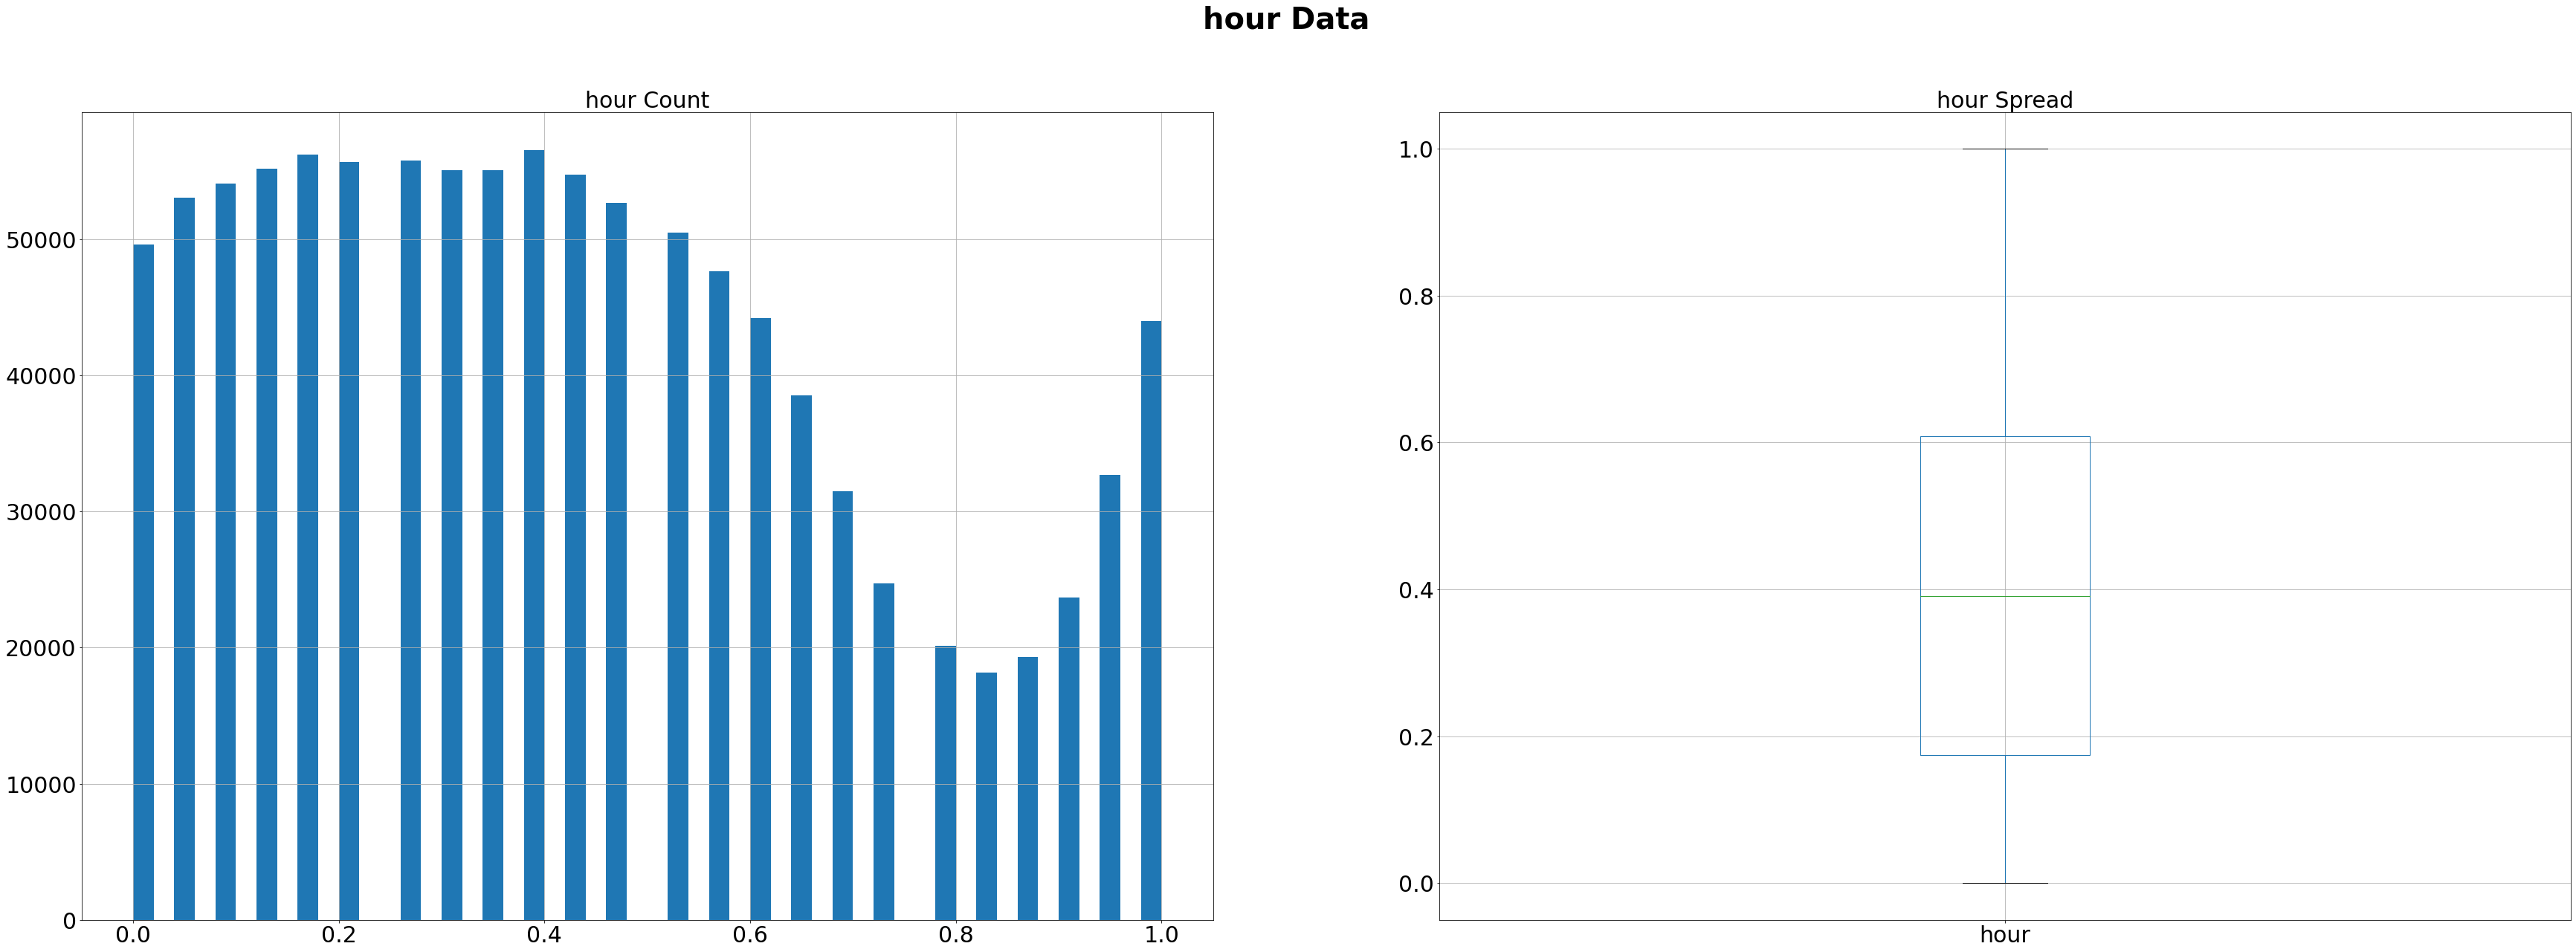

In [34]:
Normality_Check('hour')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


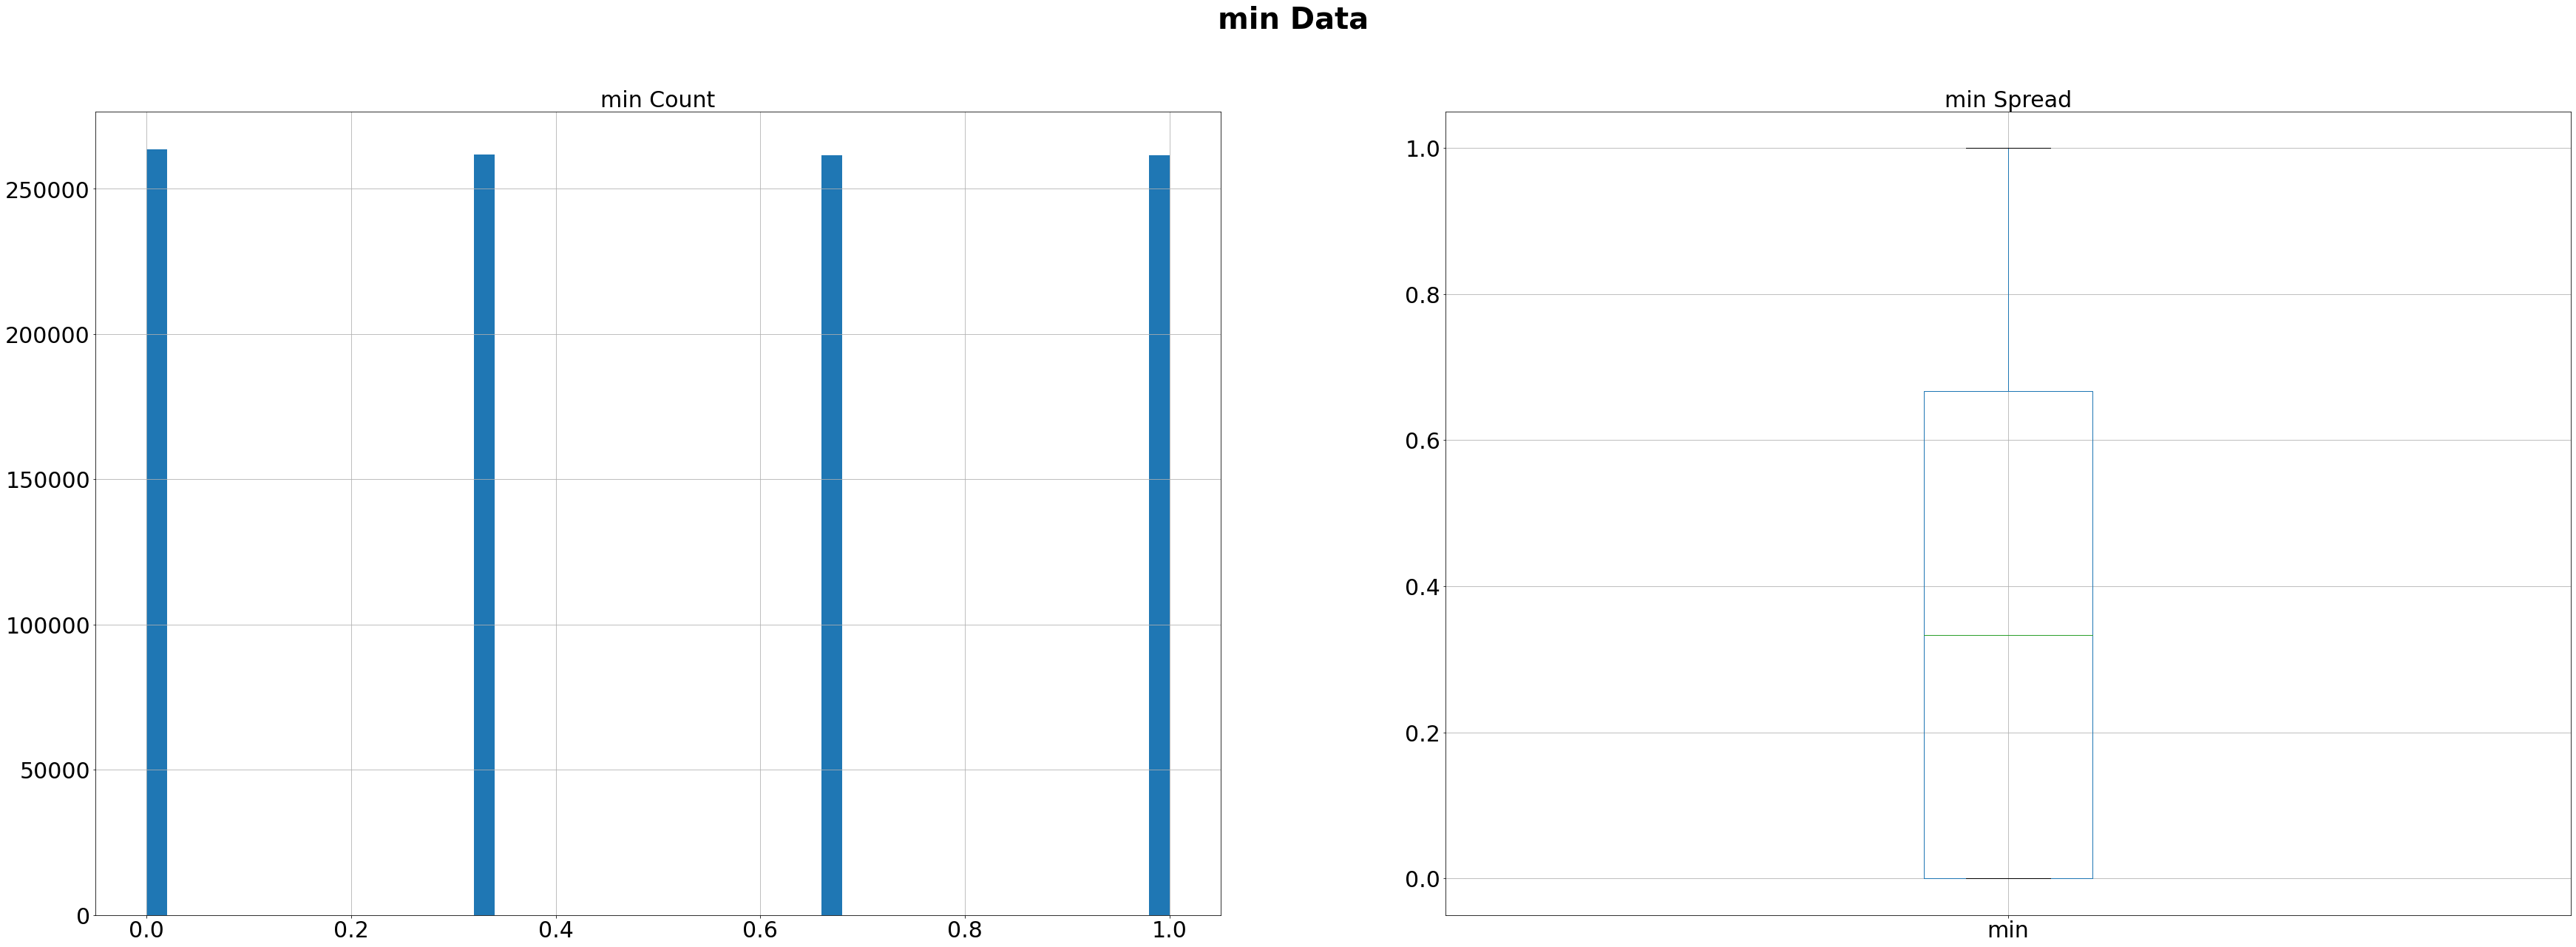

In [35]:
Normality_Check('min')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


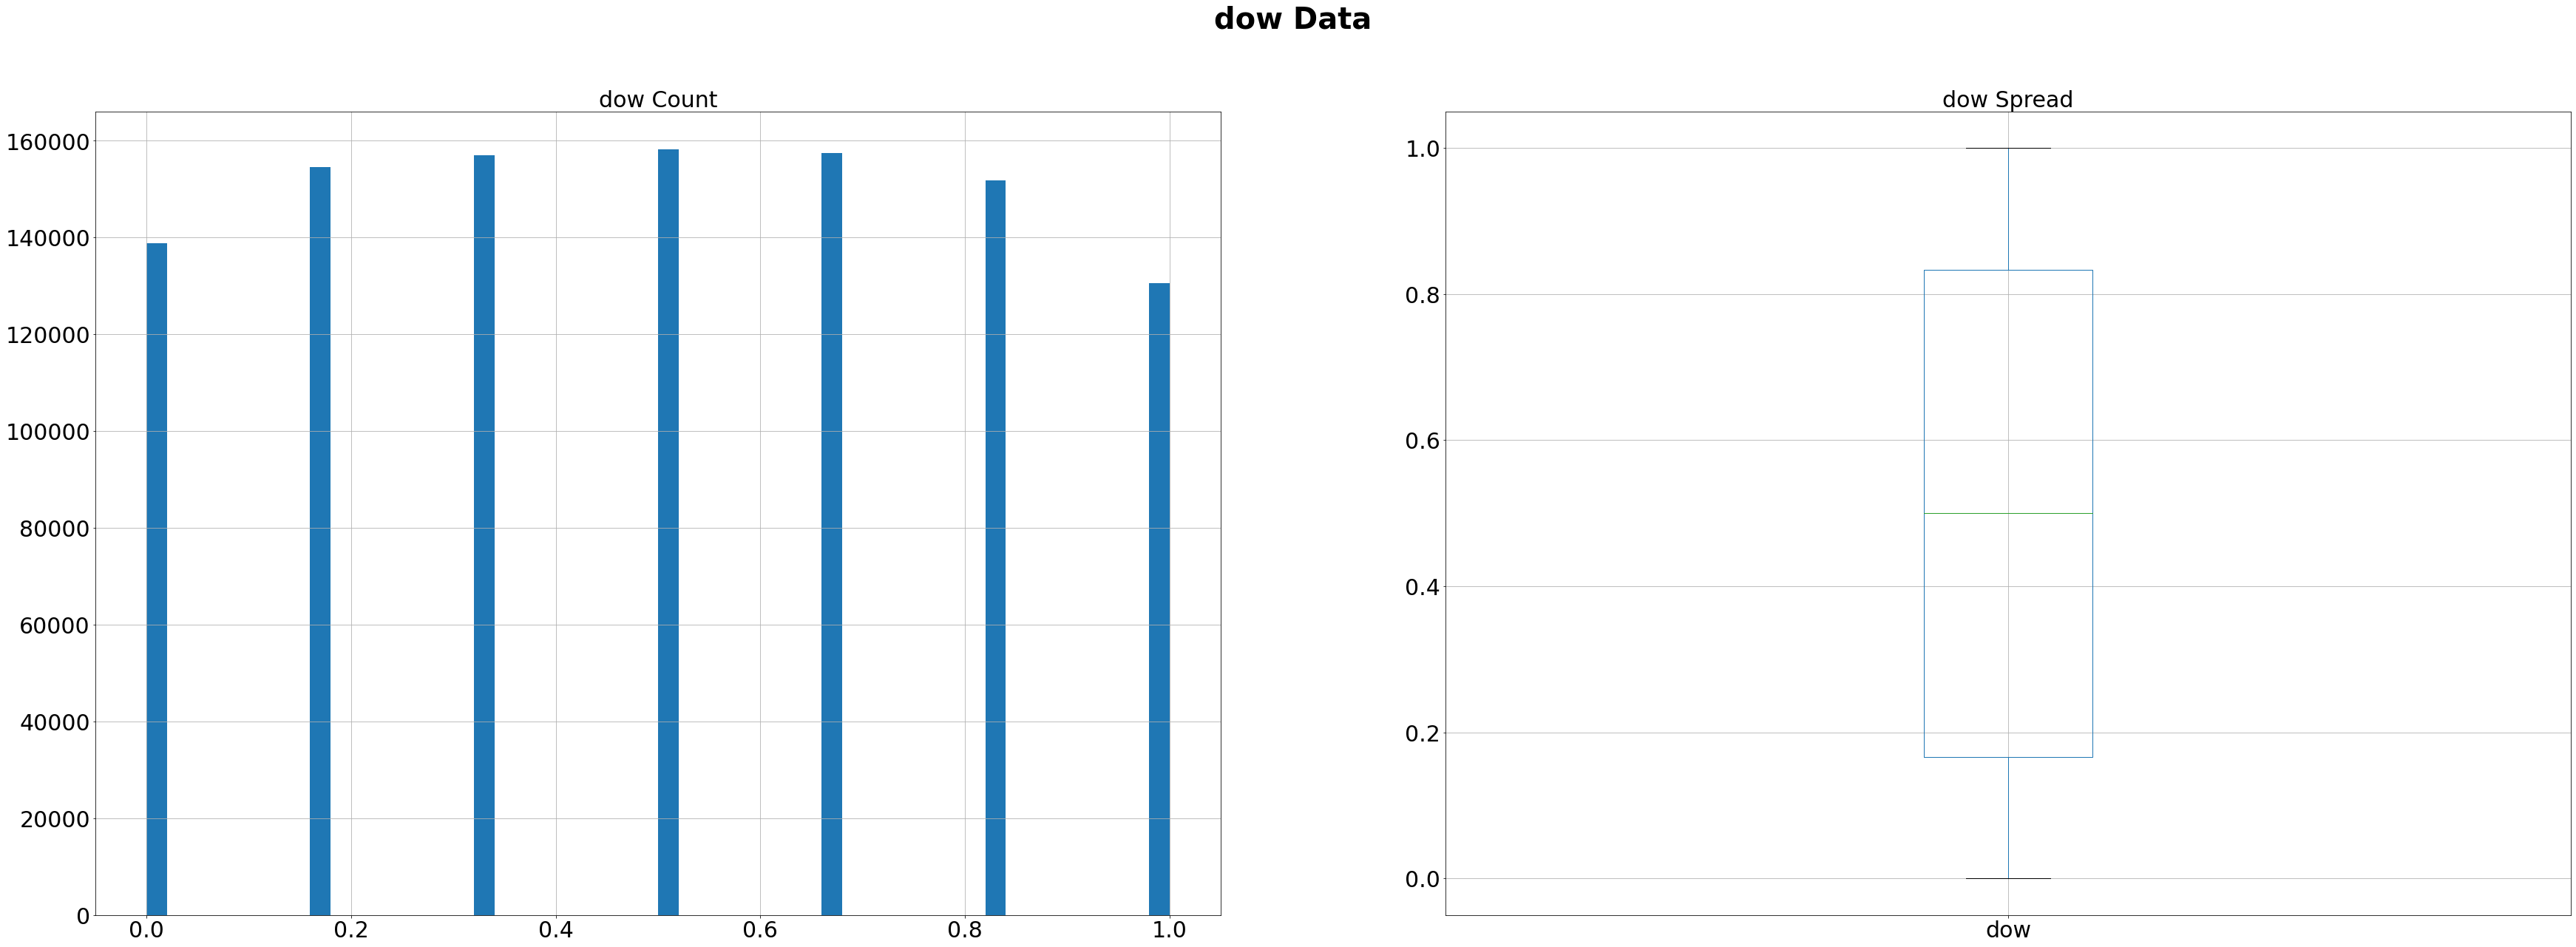

In [36]:
Normality_Check('dow')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


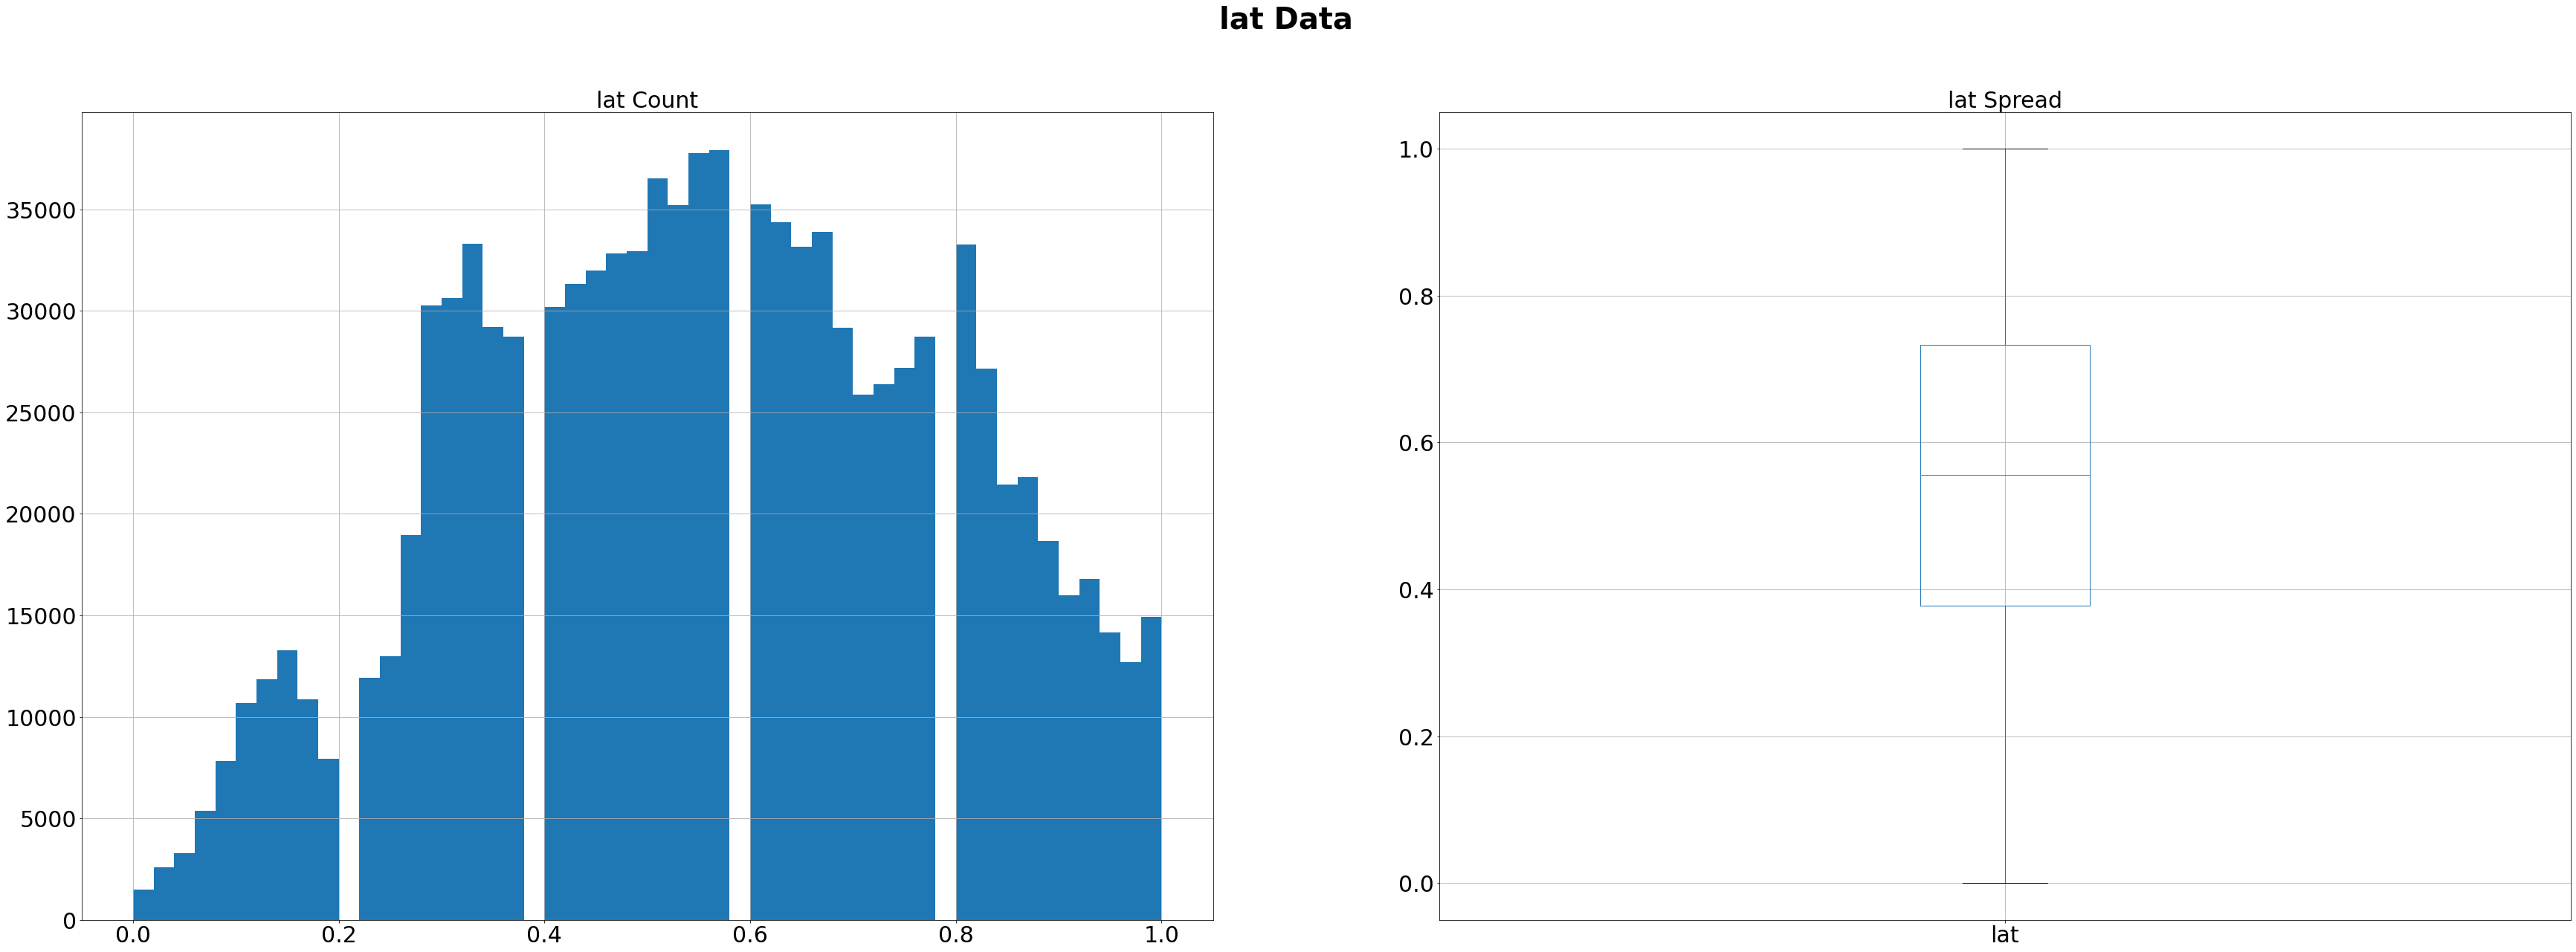

In [37]:
Normality_Check('lat')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


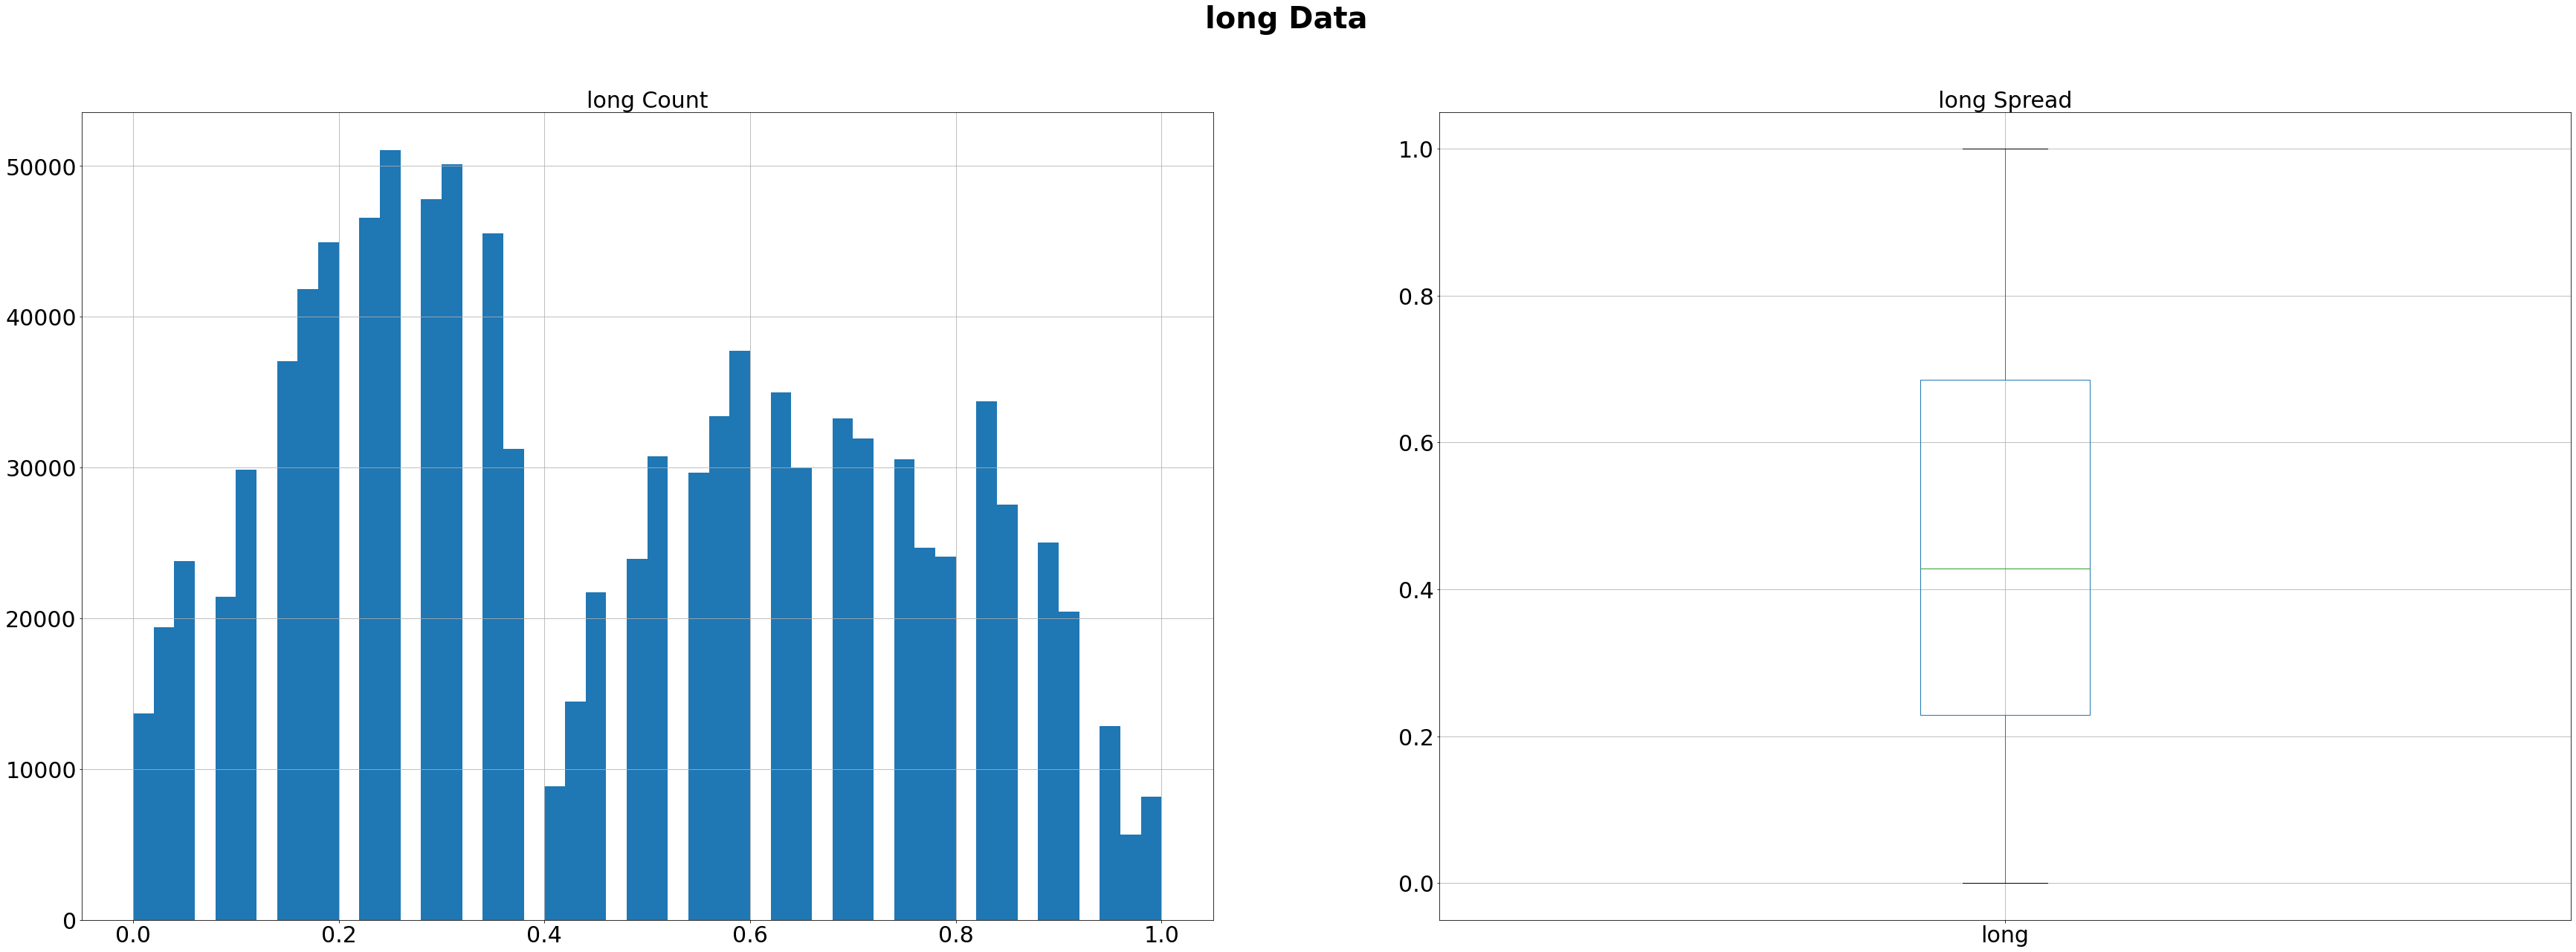

In [38]:
Normality_Check('long')

C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\envs\deep\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


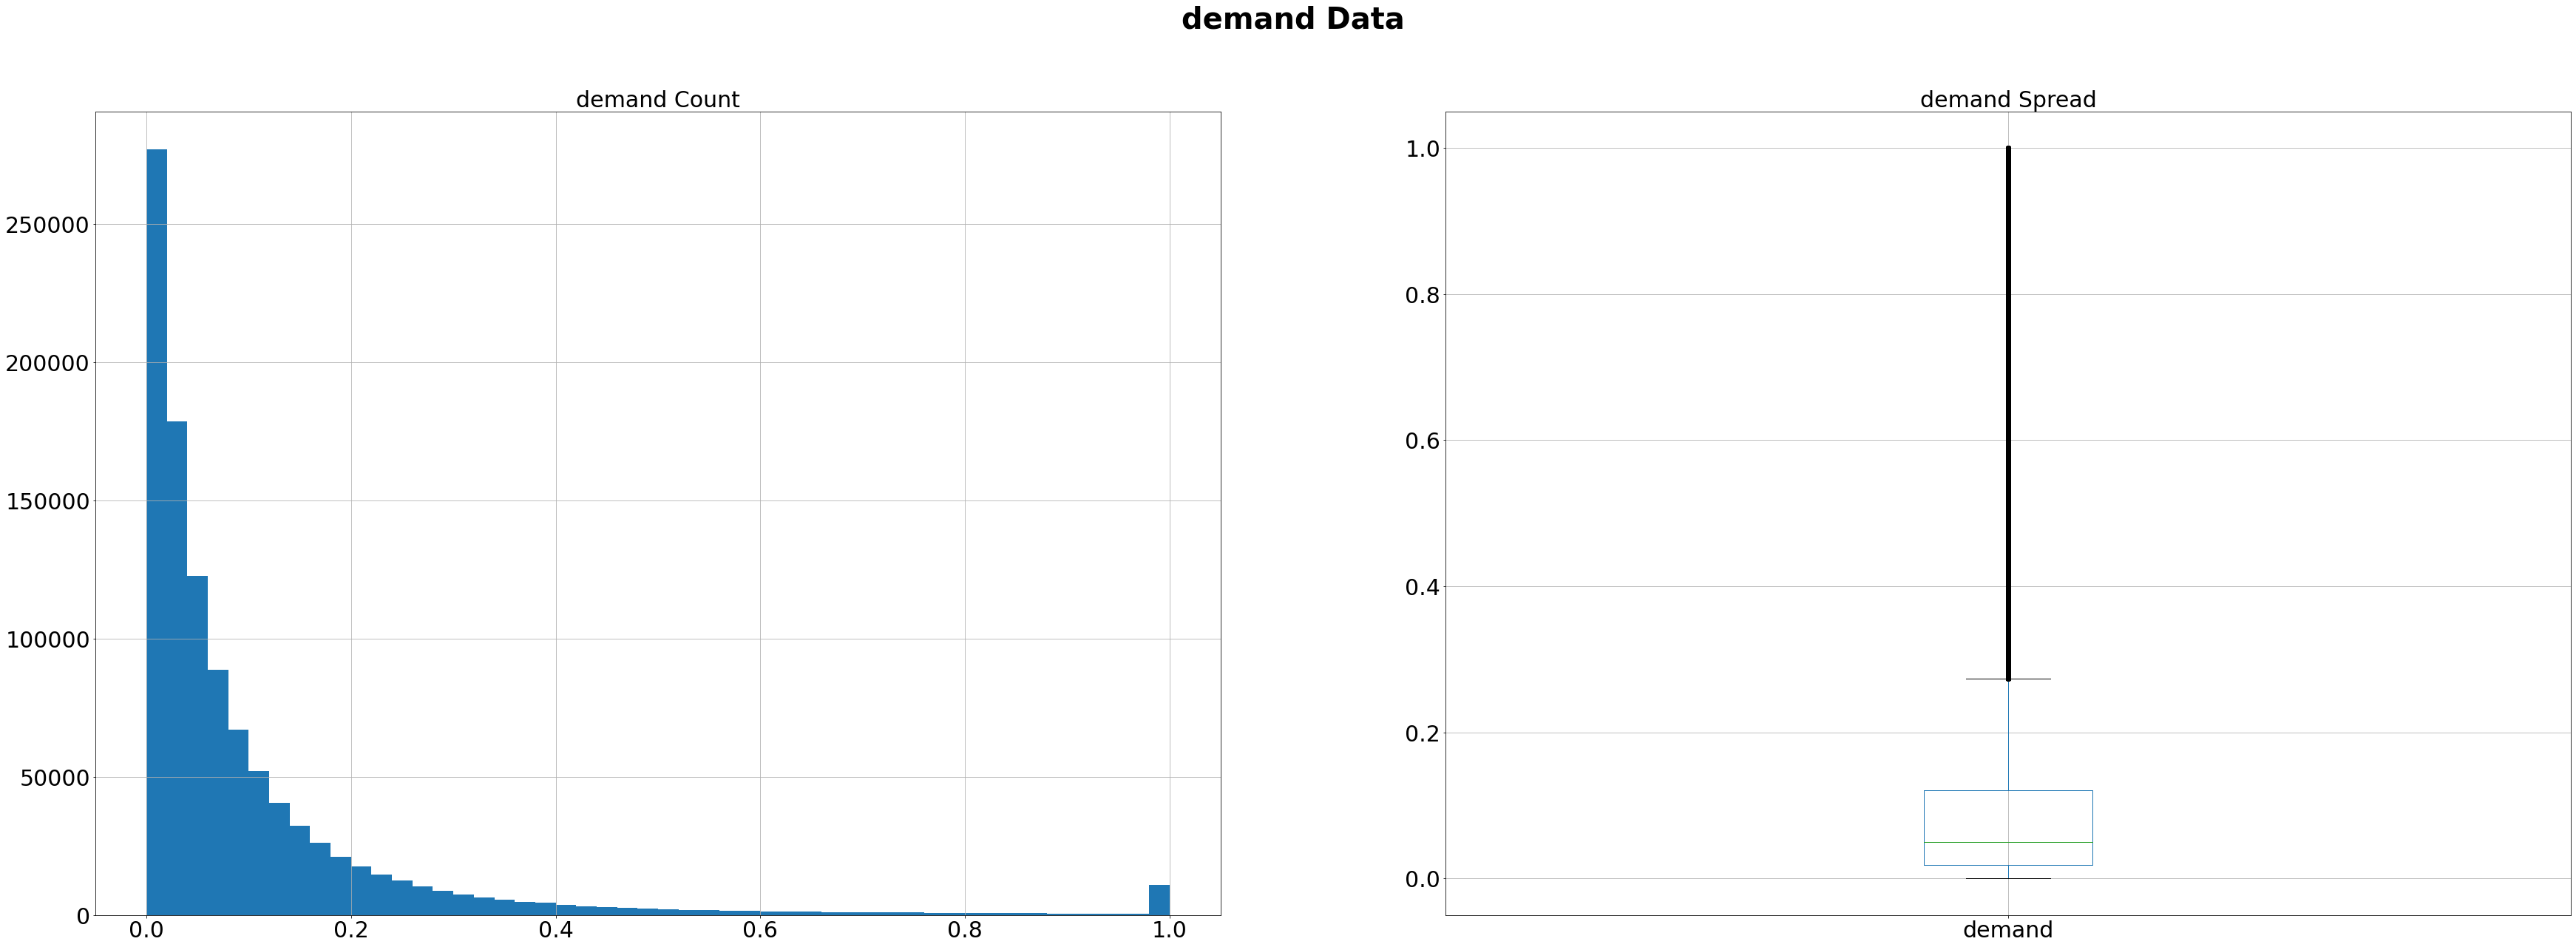

In [39]:
Normality_Check('demand')

#### Create a new excel workbook

In [41]:
writer = pd.ExcelWriter('data/Dataset_feature.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='TrafficMgmt', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()
